/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Optimum Coefficients (Torque Equation): [1.e+02 1.e-02]
Optimum Radius (m): 0.1


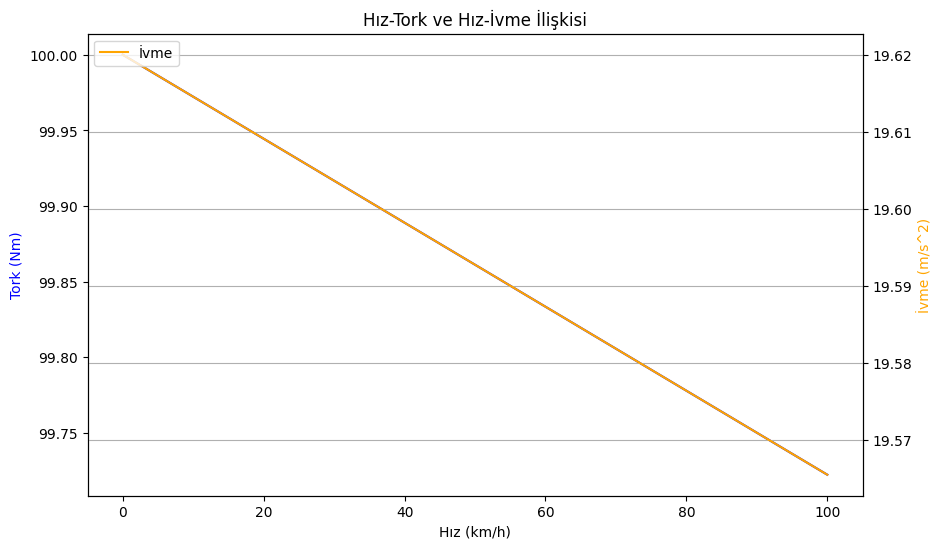

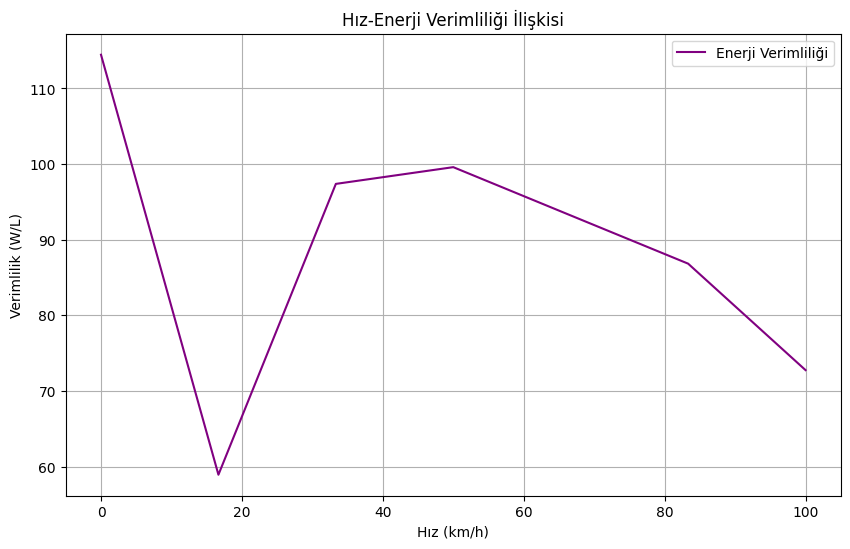

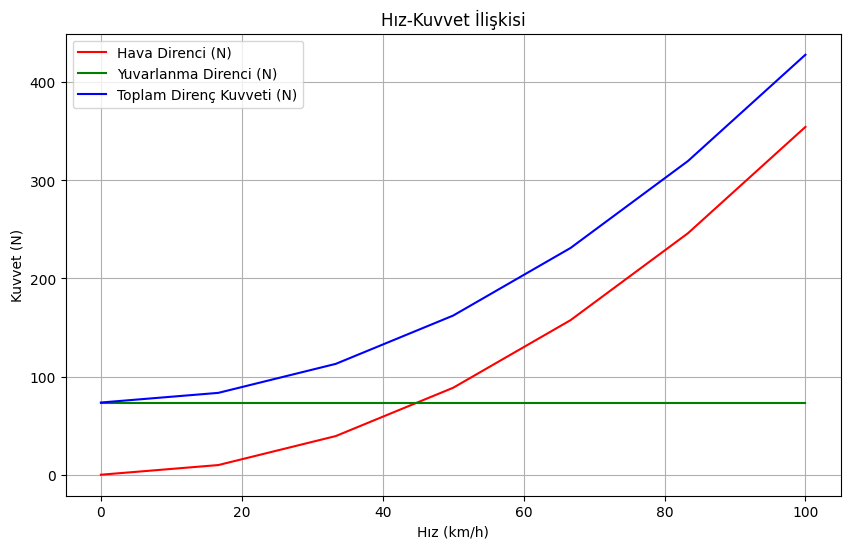

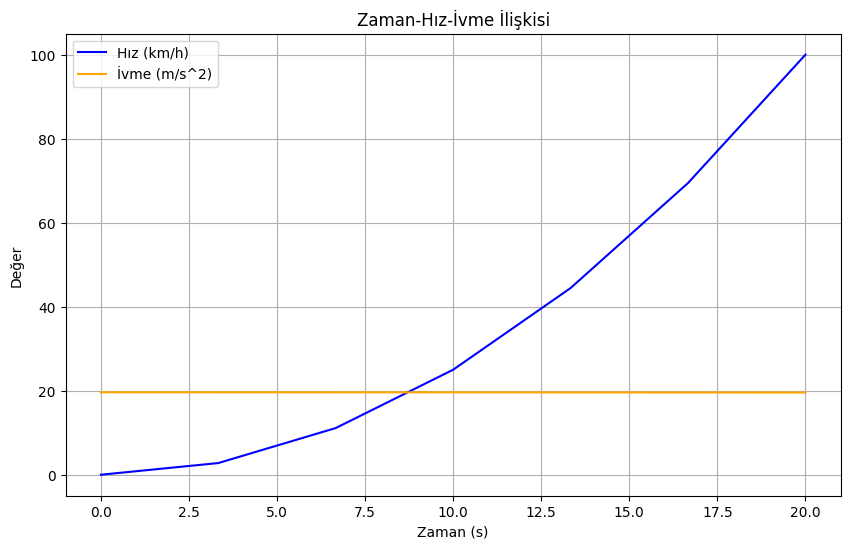

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Veriler (örnek veriler, doğrudan PDF'teki bilgilerden alınmalıdır)
power_output = np.array([0, 211.5, 408, 604.5, 811.8, 1015, 1091.2])  # Watt
fuel_consumption = np.array([0, 3.59, 4.19, 6.07, 8.71, 11.69, 15])  # Litre/dakika

# Fiziksel sabitler
density_air = 1.225  # kg/m^3 (hava yoğunluğu)
cd = 0.3  # Hava direnci katsayısı
frontal_area = 2.5  # m^2 (araç ön alanı)
rolling_resistance_coeff = 0.015  # Yuvarlanma direnci katsayısı
g = 9.81  # m/s^2 (yerçekimi ivmesi)
mass = 500  # kg (araç kütlesi)

# Hız-tork ilişkisinin enerji ile modellenmesi için örnek formüller
def torque(speed, coeff):
    """Tork hesaplama (örnek denklem)"""
    return coeff[0] - coeff[1] * speed

def acceleration(torque, mass, radius):
    """İvme hesaplama (örnek denklem)"""
    return (torque / (mass * radius)) * g

def aerodynamic_drag(speed):
    """Hava direnci kuvveti"""
    return 0.5 * density_air * cd * frontal_area * (speed ** 2)

def rolling_resistance(mass):
    """Yuvarlanma direnci kuvveti"""
    return rolling_resistance_coeff * mass * g

# Hedef fonksiyon (yakıt tüketimini ve ivmeyi optimize et)
def objective(params):
    coeff, radius = params[:2], params[2]
    speeds = np.linspace(0, 100, len(power_output)) / 3.6  # Hız (m/s)
    torques = torque(speeds, coeff)
    accels = acceleration(torques, mass, radius)

    # Güç tüketimini hesapla
    drag_forces = aerodynamic_drag(speeds)
    rolling_forces = rolling_resistance(mass)
    total_forces = drag_forces + rolling_forces
    power_required = total_forces * speeds  # Watt

    # Verimlilik ve ivme kombinasyonunu optimize et
    efficiency = np.divide(power_output, fuel_consumption, where=(fuel_consumption != 0))
    score = -np.sum(efficiency * accels / (1 + power_required))  # Maksimize etmek için negatif alınır
    return score

# Başlangıç değerleri ve sınırlar
initial_guess = [50, 0.1, 0.3]  # Coeff[0], Coeff[1], yarıçap
bounds = [(10, 100), (0.01, 1), (0.1, 1)]

# Optimizasyon
result = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')

# Sonuçlar
optimal_params = result.x
optimal_coeff = optimal_params[:2]
optimal_radius = optimal_params[2]

print("Optimum Coefficients (Torque Equation):", optimal_coeff)
print("Optimum Radius (m):", optimal_radius)

# Görselleştirme
speeds = np.linspace(0, 100, len(power_output))  # Hız (km/h)
speeds_mps = speeds / 3.6  # Hız (m/s)
torques = torque(speeds_mps, optimal_coeff)
accels = acceleration(torques, mass, optimal_radius)

# Hız-Tork ve Hız-İvme İlişkisi Grafiği
plt.figure(figsize=(10, 6))
plt.plot(speeds, torques, label='Tork', color='blue')
plt.xlabel('Hız (km/h)')
plt.ylabel('Tork (Nm)', color='blue')
plt.title('Hız-Tork ve Hız-İvme İlişkisi')
plt.twinx()
plt.plot(speeds, accels, label='İvme', color='orange')
plt.ylabel('İvme (m/s^2)', color='orange')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# Enerji Verimliliği Grafiği
efficiency = np.divide(power_output, fuel_consumption, where=(fuel_consumption != 0))  # Enerji verimliliği
plt.figure(figsize=(10, 6))
plt.plot(speeds, efficiency, label='Enerji Verimliliği', color='purple')
plt.xlabel('Hız (km/h)')
plt.ylabel('Verimlilik (W/L)')
plt.title('Hız-Enerji Verimliliği İlişkisi')
plt.legend()
plt.grid()
plt.show()

# Güç ve Direnç Kuvvetleri Grafiği
drag_forces = aerodynamic_drag(speeds_mps)
rolling_forces = np.full_like(speeds, rolling_resistance(mass))  # Sabit yuvarlanma direnci
total_forces = drag_forces + rolling_forces
power_required = total_forces * speeds_mps

plt.figure(figsize=(10, 6))
plt.plot(speeds, drag_forces, label='Hava Direnci (N)', color='red')
plt.plot(speeds, rolling_forces, label='Yuvarlanma Direnci (N)', color='green')
plt.plot(speeds, total_forces, label='Toplam Direnç Kuvveti (N)', color='blue')
plt.xlabel('Hız (km/h)')
plt.ylabel('Kuvvet (N)')
plt.title('Hız-Kuvvet İlişkisi')
plt.legend()
plt.grid()
plt.show()

# Zaman Tabanlı Performans
time = np.linspace(0, 20, len(speeds))  # 20 saniye boyunca
speeds_time = speeds_mps * (time / max(time))  # Hızın zamana göre değişimi
torques_time = torque(speeds_time, optimal_coeff)
accels_time = acceleration(torques_time, mass, optimal_radius)

plt.figure(figsize=(10, 6))
plt.plot(time, speeds_time * 3.6, label='Hız (km/h)', color='blue')
plt.plot(time, accels_time, label='İvme (m/s^2)', color='orange')
plt.xlabel('Zaman (s)')
plt.ylabel('Değer')
plt.title('Zaman-Hız-İvme İlişkisi')
plt.legend()
plt.grid()
plt.show()
